# Workshop 2

Hi and welcome to the second workshop. This session will focus on spatial discretisation and introduce you to the Flopy modelgrid object, which is used for exporting model information in various formats. Modflow-6 includes 3-types of grid discretisation namely structured (DIS), vertices (DISV) and unstructured (DISU) that we will explore with Flopy. Also included in this workshop will be an introduction to using Gridgen (get it [here](https://github.com/MODFLOW-USGS/executables)) to build a quadtree refined model mesh. There are some optional dependencies for Flopy that you will need to have installed in your environment otherwise you may not be able to execute some parts of the workshop.

Go to this [webpage](https://flopy.readthedocs.io/en/latest/md/optional_dependencies.html) to find a list of all Flopy optional dependencies. You will need pyshp, shapely, rasterio (with rasterstats and affine) and scipy.

# A structured model grid
The structured model grid discretizes space into layers (z), rows (x), and columns (y). This is identical to what was used in all previous versions of MODFLOW excluding MODFLOW-USG. An important difference however is that those previous versions of MODFLOW used finite-differences while MODFLOW-6 uses control-volume finite-differences (also used by MODFLOW-USG). The benefit of using structured grids is that it will always satisfy the assumptions of the control-volume finite-difference method. While the other grid types can violate the assumption, which leads to some error in the solution. You can read more about this in the MODFLOW-6 user manual (note this is ***not*** the mf6io.pdf document). 

# Imports

In [1]:
import os
import sys
import shutil
import platform
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

print(f"Pandas version = {pd.__version__}")
print(f"Numpy version = {np.__version__}")
print(f"Flopy version = {flopy.__version__}")
print(f"Matplotlib version = {matplotlib.__version__}")

Pandas version = 2.0.3
Numpy version = 1.25.2
Flopy version = 3.4.1
Matplotlib version = 3.7.2


# Folders

In [2]:
# Setup some folders
ws2 = os.path.join('workshop_2') # here we are making a path not creating the folder
gis_f = os.path.join(ws2,'GIS') # creating a sub-directory path for our gis input/output
model_f = os.path.join(ws2,'model') # creating a sub-directory path for our model input/output
plots_f = os.path.join(ws2,'plots') # creating a sub-directory path for our plots
for path in [ws2,gis_f,model_f,plots_f]:
    if os.path.exists(path): # here we are asking if the path exists on the computer. 
        shutil.rmtree(path)# if it does exist, delete it and all the files in it
        os.mkdir(path) # then remake it
    else:
        os.mkdir(path) # if it doesn't exist then make the folder

# Setup basic simulation level objects

For the purposes of this demonstration we don't need anything more than the basic simualtion level objects. I am assuming that you completed the previous workshop, which means you know what the following block of code is doing. If not, consider doing the first workshop. We will change these objects as we explore other grids. 

In [3]:
simulation_name = 'MySim' # setting a name for our simulation
sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
model_name = 'flow' # setting a name for our model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

# Input blocks for the strcutured discretisation input file

Take a look at the mf6io.pdf document for the DIS input file. There are three input blocks, OPTIONS (common for most input files), DIMENSIONS and GRIDDATA. We will explore how to change entries in the DIMENSIONS and GRIDDATA blocks first plus provide brief descriptions of what these settings mean. You are encouraged to read the document for more detail if required. The OPTIONS block will be discussed in more detail later.

# Building a uniform spaced three layer DIS object
Terminology used:
* node = the model cell centre where the solution is calculated
* model cell = refers to the set of rectilinear shapes that enclose the node

Points to note with structured grids:
1. Each layer will be identical to the next in terms of node location. Think about what this means for each model cell.
2. Layers can have variable top and bottom elevations that don't need to be thesame 


In [4]:
# A simple uniform single layer grid
nlay = 3 # the number of layers we want
nrow = 3 # you guesssed it, the number of rows we want
ncol = 3 # the number of columns we want
delr = 1 # our row spacing
delc = 1 # our column spacing
top = 1 # the top elevation of each model cell
bot = 0 # the bottom elevation of each model cell
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=bot) # creating the dis object

# Now we can build a modelgrid object

I find it useful to think of the modelgrid object as a frame will be used to guide further processing. You can retrieve information about your grid too as will be demonstrated.

In [5]:
mg = gwf.modelgrid # note that the model grid object is specific to the model

# Plotting the modelgrid

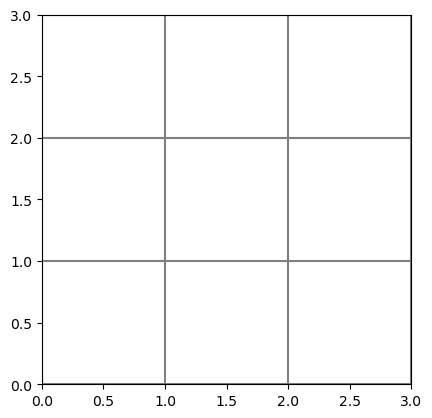

In [6]:
mg.plot() # gives you a basic view of the grid top down looking at layer 1

In [7]:
type(mg) # checking the type of mg

flopy.discretization.structuredgrid.StructuredGrid

In [8]:
# What is the difference between the botm in the dis object versus the botm in the mg object?
print(type(dis.botm),'\n',dis.botm) 
print(type(mg.botm),'\n', mg.botm)
# Are they different? One is a flopy specific data structure the other is a numpy array

<class 'flopy.mf6.data.mfdataarray.MFArray'> 
 {constant 0}

<class 'numpy.ndarray'> 
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


They represent the same thing. Lets write the simulation and have a closer look at the dis input file.

In [9]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...


In [10]:
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,"flow.dis"))]
# You should see the three input blocks that we discussed earlier.

# File generated by Flopy version 3.4.1 on 09/25/2023 at 12:22:13.
BEGIN options
END options

BEGIN dimensions
  NLAY  3
  NROW  3
  NCOL  3
END dimensions

BEGIN griddata
  delr
    CONSTANT       1.00000000
  delc
    CONSTANT       1.00000000
  top
    CONSTANT       1.00000000
  botm
    CONSTANT       0.00000000
END griddata



In [11]:
# What is the shape of the array storing the cell bottoms?
np.shape(mg.botm) # this should be in sequence l,r,c or nlay, nrow, ncol

(3, 3, 3)

# Does this grid make sense?

If you were to continue with this grid as your model, what would happen? You could complete constructing the model and get to the point where you run the simulation and it will likely fail. Some layers have zero thickness. Flopy is happy to create a discretisation file with zero thickness layers because that is what you asked for. As the modeller, ***it is your responsibility to check your input files***. Do not presume that because Flopy executed without error that your input files are fine. Flopy is a tool to help you create those files – it can still produce input files that will cause your model to fail. 

In [12]:
# check the layer thickness via the model grid object
mg.cell_thickness

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[-0., -0., -0.],
        [-0., -0., -0.],
        [-0., -0., -0.]],

       [[-0., -0., -0.],
        [-0., -0., -0.],
        [-0., -0., -0.]]])

In [13]:
# Or check if there are any cells with zero or less thickness
test = mg.cell_thickness<=0.0 # will create a boolean array, that is, an array of True and False
test.any() # If any instances of True exist in the boolean array test. In other words do I have a cell with less than zero thickness

True

# Different layer elevations plus row and column spacing 

In order to set up a structured grid with variable row and column spacing and/or layer elevations we have to provide the dis object with lists or arrays instead of scalars for delr, delc, top and bottom.

In [14]:
# remove previous gwf, dis and mg objects
del gwf
del dis
del mg
# We'll stick with the same grid we had previously but change how we input delr, delc, top and bot
# A simple uniform single layer grid
nlay = 3 # the number of layers we want
nrow = 3 # you guesssed it, the number of rows we want
ncol = 5 # the number of columns changing this.
delr = [x/2 for x in range(1,6)] # our row spacing !!! WHAAAT but don't we only have 3 rows
delc = [x*1.1 for x in range(1,4)] # our column spacing !!! WHAAAT but we have 5 columns
# delr is spacing ALONG a row, NOT spacing between rows therefore the number of elements of delr = ncol
# delc is spacing ALONG a column, NOT spacing between columns therefore the number of elements of delc = nrow
print(delr)
print(delc)

[0.5, 1.0, 1.5, 2.0, 2.5]
[1.1, 2.2, 3.3000000000000003]


In [15]:
# This is a simple way to create an array with different layer elevations
my_bots_layer1 = np.ones((1,nrow,ncol))*2.0 
# np.ones((1,3,3)) creates an 2D 3x3 array filled with ones, I then mutiply this by 2.0 to get my layer bottom elevations
# there are simpler ways to do this but we will use this same method with other Flopy packages in subsequent workshops 
my_bots_layer2 = np.ones((1,nrow,ncol))*1.5 
my_bots_layer3 = np.ones((1,nrow,ncol))*1.0 
# now the dis object will want a single 3D array and we currently have three 2D arrays so we need to "stack" them
all_my_bots = np.vstack((my_bots_layer1,my_bots_layer2,my_bots_layer3)) # this combines the 2D arrays into a 3D
all_my_bots

array([[[2. , 2. , 2. , 2. , 2. ],
        [2. , 2. , 2. , 2. , 2. ],
        [2. , 2. , 2. , 2. , 2. ]],

       [[1.5, 1.5, 1.5, 1.5, 1.5],
        [1.5, 1.5, 1.5, 1.5, 1.5],
        [1.5, 1.5, 1.5, 1.5, 1.5]],

       [[1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ]]])

In [16]:
# Use the same approach to assign the tops ensuring they are greater than layer 1 bottoms
top = np.ones((1,nrow,ncol))*3.0 
top

array([[[3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.]]])

In [17]:
# build a new gwf object
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file
# build our new dis object
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=all_my_bots) # creating the dis object

In [18]:
# Because we changed dis we need to reset what mg is
mg = gwf.modelgrid

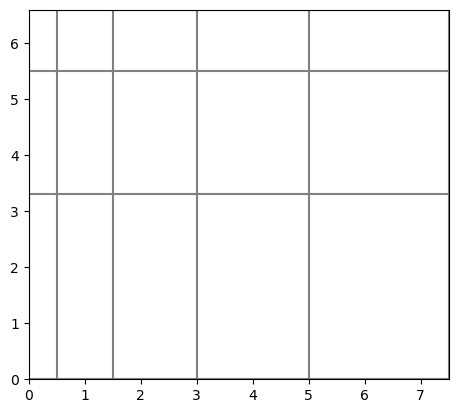

In [19]:
# now look at model grid
mg.plot() # recall that this is viewing the grid from the top

In [20]:
# Or check if there are any cells with zero or less thickness
test = mg.cell_thickness<=0.0 # will create a boolean array, that is, an array of True and False
test.any() # If any instances of True exist in the boolean array test. In other words do I have a cell with less than zero thickness

False

# The idomain array
The idomain array is used to deactivate model cells that are part of the grid. Idomain arrays are used with all three types of model grids in Modflow-6. The structured grid allows for the creation of rectangular grids but if your system boundaries don't align with the rectangle then you may want to deactivate those cells. The idomain array therefore has the same number of elements in it as your complete model grid. Values of one indicate active model cells while values of zero are inactive cells. Previous versions of MODFLOW used an array called IBOUND to achieve the same thing. The IBOUND array could also include negative numbers to represent fixed head locations. MODFLOW-6 does not specify fixed heads in this manner. Negative numbers still deactivate the cell but also trigger the formation of a vertical pass through connection, that is, the first active cell above the cell with a negative idomain value will be connected to the first active cell below. If you don't specify an idomain array the default is that all model grid cells are active.

In [21]:
my_idom = np.ones((nlay,nrow,ncol)) # creates an array with all ones so all active cells
print('\nall active\n',my_idom)
# deactivate all layers at cell (3,3)
for x in range(nlay): # loop through the layer index
    my_idom[x,2,2]=0 # set the value at row,col = 3,3 to zero. 
# Note zero based indexing in Python means that 2,2 = 3,3 in the input file
print('\ndeactivate lower right corner\n',my_idom)
# Now deactivate (2,1,1) and link (1,1,1) to (3,1,1)
my_idom[1,0,0]=-1
print('\nalso deactivate upper left corner in layer 2 only plus add vertical pass through\n',my_idom)


all active
 [[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]

deactivate lower right corner
 [[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1.]]]

also deactivate upper left corner in layer 2 only plus add vertical pass through
 [[[ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  0.  1.  1.]]

 [[-1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  0.  1.  1.]]

 [[ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  0.  1.  1.]]]


In [22]:
# delete the previous dis and mg objects
del dis
del mg
# create a new dis object but this time pass in the idomain array
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,
                              delr=delr,delc=delc,top=top,
                              botm=all_my_bots, idomain=my_idom) # creating the dis object

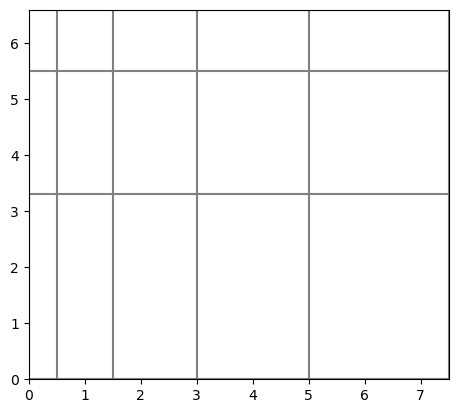

In [23]:
# create the model grid object and plot it note the idomain array is not reflected in the plot of the modelgrid.
mg = gwf.modelgrid
mg.plot()

# Where are my nodes exactly
The model nodes in addition to the cell vertices are given co-orodinates that are determined from the lower left corner of the grid. This is clearly evident in the plot above where the lower left corner is 0,0

In [24]:
# How to get a list of node coordinates
xcc = mg.get_xcellcenters_for_layer(0) # the zero here is for layer1
ycc = mg.get_ycellcenters_for_layer(0)
# now we combine them to form tuples of x and y
coords = list(zip(xcc.flatten(),ycc.flatten()))
coords
# look carefully at the list. The first entry is the top left node location. Which one is the lower left?

[(0.25, 6.050000000000001),
 (1.0, 6.050000000000001),
 (2.25, 6.050000000000001),
 (4.0, 6.050000000000001),
 (6.25, 6.050000000000001),
 (0.25, 4.4),
 (1.0, 4.4),
 (2.25, 4.4),
 (4.0, 4.4),
 (6.25, 4.4),
 (0.25, 1.6500000000000004),
 (1.0, 1.6500000000000004),
 (2.25, 1.6500000000000004),
 (4.0, 1.6500000000000004),
 (6.25, 1.6500000000000004)]

# Projecting the grid into space

Perhaps you want to configure your grid to represent an area to discretise for the purpose of building a groundwater model. You may want to project the grid onto a map so that it can be viewed in a GIS. The XORIGIN and YORIGIN variables in the options block of all three types of spatial discretization files facilitate this. Lets use the same information to build a new dis object but provide values for the XORIGIN and YORIGIN.

In [25]:
# first delete the previous dis and mg objects
del dis
del mg
# now rebuild dis. Note we still have all our other variables available in memory 
# so we don't need to redefine values for variables.
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,
                              delr=delr,delc=delc,top=top,
                              botm=all_my_bots, idomain=my_idom,
                             xorigin=100.0, yorigin=50.0) # creating the dis object

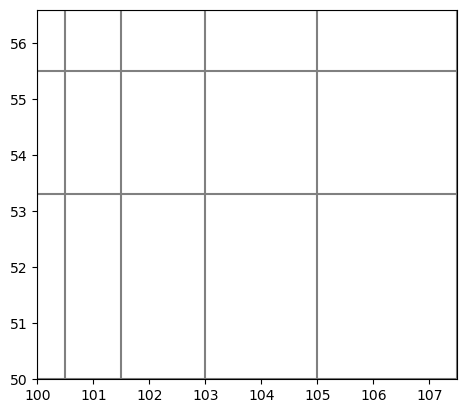

In [26]:
# get a new modelgrid object
mg = gwf.modelgrid
mg.plot() # take a look at the values on the 'axes' now.

In [27]:
# What are the node new coordinates
xcc = mg.get_xcellcenters_for_layer(0) # the zero here is for layer1
ycc = mg.get_ycellcenters_for_layer(0)
coords = list(zip(xcc.flatten(),ycc.flatten()))
coords
# So what are the xorigin and yorigin variables doing exactly.

[(100.25, 56.05),
 (101.0, 56.05),
 (102.25, 56.05),
 (104.0, 56.05),
 (106.25, 56.05),
 (100.25, 54.4),
 (101.0, 54.4),
 (102.25, 54.4),
 (104.0, 54.4),
 (106.25, 54.4),
 (100.25, 51.65),
 (101.0, 51.65),
 (102.25, 51.65),
 (104.0, 51.65),
 (106.25, 51.65)]

# Rotating the grid

In addition to using the XORIGIN and YORIGIN settings for your grid, you cal also rotate it in space.

In [28]:
# first delete the previous dis and mg objects
del dis
del mg
# now rebuild dis. Note we still have all our other variables available in memory 
# so we don't need to redefine values for variables.
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,
                              delr=delr,delc=delc,top=top,
                              botm=all_my_bots, idomain=my_idom,
                             xorigin=100.0, yorigin=50.0,
                             angrot=30) # rotate 60 degrees around the x axis

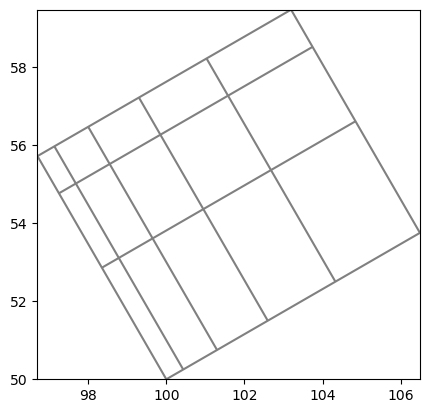

In [29]:
# get a new modelgrid object
mg = gwf.modelgrid
mg.plot() # take a look at the values on the 'axes' now.

In [30]:
# What are the node new coordinates
xcc = mg.get_xcellcenters_for_layer(0) # the zero here is for layer1
ycc = mg.get_ycellcenters_for_layer(0)
coords = list(zip(xcc.flatten(),ycc.flatten()))
coords

[(97.19150635094611, 55.36445369289585),
 (97.84102540378444, 55.73945369289585),
 (98.923557158515, 56.36445369289585),
 (100.43910161513776, 57.23945369289585),
 (102.38765877365275, 58.36445369289585),
 (98.0165063509461, 53.93551177665153),
 (98.66602540378443, 54.31051177665153),
 (99.74855715851498, 54.93551177665153),
 (101.26410161513775, 55.81051177665153),
 (103.21265877365273, 56.93551177665153),
 (99.3915063509461, 51.55394191624432),
 (100.04102540378443, 51.92894191624432),
 (101.12355715851498, 52.55394191624432),
 (102.63910161513775, 53.42894191624432),
 (104.58765877365273, 54.55394191624432)]

# An applied example

In this example you will be provided with a polygon shape file representing a model domain. You will have to build a strcutured grid with uniform 100 m x 100 m cells that encompasses the domain, then refine your grid down to 25 m x 25 m cells around two pumping wells whose locations are provided using a point shapefile. We will be exporting the grid as a shapefile so that we can see if we are projecting and sizing our grid correctly.

In [31]:
# First we clear all the existing Flopy objects
for obj in [sim,tdis,ims,gwf,dis,mg]:
 del obj

In [32]:
# you have to copy the shape files you need to your GIS subdirectory in your workshop_2 folder
# the files are located in a folder called files located in the same folder that the notebook is running.

# create a path to the folder
fpath=os.path.join('files')
# the files are named sgrid_poly.shp and sgrid_points.shp but the shp files are not the only files you need to load 
# into a GIS. So we need to get all the files that have the same names.
flist = [x for x in os.listdir(fpath) if (x.startswith('sgrid_poly')) or (x.startswith('sgrid_points'))] 
print(flist)
# Now we need to copy those files over to 
for fyl in flist:
    shutil.copyfile(os.path.join(fpath,fyl),os.path.join(gis_f,fyl))
# take a look in your workshop GIS folder to see if the files were copied

['sgrid_points.cpg', 'sgrid_points.dbf', 'sgrid_points.prj', 'sgrid_points.qix', 'sgrid_points.shp', 'sgrid_points.shx', 'sgrid_poly.cpg', 'sgrid_poly.dbf', 'sgrid_poly.prj', 'sgrid_poly.qix', 'sgrid_poly.shp', 'sgrid_poly.shx']


# Follow these steps
1. Launch your prefered GIS program
2. Load the shape files (check one of the prj files for the projection information)
3. Figure out the coordinates needed for the lower left of your model grid 
4. Build a basic simualtion including a model object (hint you can copy and paste from a previous cell)
5. Work out how many rows and columns you will need to cover the polygon (don't worry about refining for now or top and botm)
6. Build your structured dis object (hint length units need to be specified as 'meters')

In [33]:
simulation_name = 'MySim' # setting a name for our simulation
sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
model_name = 'flow' # setting a name for our model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

In [34]:
nlay = 1
nrow = 24
ncol = 124
delc = 100.0
delr = 100.0
top = 1.0
botm = 0.0
x = 686825.7084327207412571
y = 7440206.9828847106546164
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,
                              delr=delr,delc=delc,top=top,
                              botm=botm, xorigin=x, yorigin=y) # creating the dis object

# Exporting the grid as a shape file
Use the line below to export your grid as a shapefile to the sub-directory for GIS that you made earlier.

In [35]:
# this assumes you named your instance of the flopy.mf6.ModflowGwfdis class,'dis'
dis.export(os.path.join(gis_f,'dis.shp')) # ignore the warnings
# Check yor GIS folder for the exported shape file

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:318: UserWarning: Failed to get data for idomain array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


In [36]:
# lets take a quick look at our nodes
mg = gwf.modelgrid
xcc = mg.get_xcellcenters_for_layer(0) # the zero here is for layer1
ycc = mg.get_ycellcenters_for_layer(0)
coords = list(zip(xcc.flatten(),ycc.flatten()))
coords

[(686875.7084327207, 7442556.982884711),
 (686975.7084327207, 7442556.982884711),
 (687075.7084327207, 7442556.982884711),
 (687175.7084327207, 7442556.982884711),
 (687275.7084327207, 7442556.982884711),
 (687375.7084327207, 7442556.982884711),
 (687475.7084327207, 7442556.982884711),
 (687575.7084327207, 7442556.982884711),
 (687675.7084327207, 7442556.982884711),
 (687775.7084327207, 7442556.982884711),
 (687875.7084327207, 7442556.982884711),
 (687975.7084327207, 7442556.982884711),
 (688075.7084327207, 7442556.982884711),
 (688175.7084327207, 7442556.982884711),
 (688275.7084327207, 7442556.982884711),
 (688375.7084327207, 7442556.982884711),
 (688475.7084327207, 7442556.982884711),
 (688575.7084327207, 7442556.982884711),
 (688675.7084327207, 7442556.982884711),
 (688775.7084327207, 7442556.982884711),
 (688875.7084327207, 7442556.982884711),
 (688975.7084327207, 7442556.982884711),
 (689075.7084327207, 7442556.982884711),
 (689175.7084327207, 7442556.982884711),
 (689275.7084327

In [37]:
# Write a new simulation
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...


In [38]:
# Now look at the flow.dis input file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,"flow.dis"))]

# File generated by Flopy version 3.4.1 on 09/25/2023 at 12:53:29.
BEGIN options
  XORIGIN  6.86825708E+05
  YORIGIN  7.44020698E+06
END options

BEGIN dimensions
  NLAY  1
  NROW  24
  NCOL  124
END dimensions

BEGIN griddata
  delr
    CONSTANT     100.00000000
  delc
    CONSTANT     100.00000000
  top
    CONSTANT       1.00000000
  botm
    CONSTANT       0.00000000
END griddata



# Refinement: 
Consider the following issues associated with manual refinement of a structured grid

1. You will need to know how many new rows and columns are going to be added when you refine
2. You will need to know which rows and columns have different delr or delc

In [39]:
# There is an MS-Excel worksheet included in the files folder that will provide you with some assitance
# Can you see how we came up with these numbers?
new_nrow = 36
new_ncol = 142
new_delr = np.ones((new_nrow))*100
new_delr[10:26] = 25.0 # note the last index is not included in the modification
new_delc = np.ones((new_ncol))*100
new_delc[37:49] = 25.0 # note the last index is not included in the modification
new_delc[81:93] = 25.0 # note the last index is not included in the modification

In [40]:
# rebuild the new dis object and export the grid as a shape file
x = 686825.7084327207412571
y = 7440206.9828847106546164
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,
                              nrow=new_nrow,
                              ncol=new_ncol,
                              delr=new_delc,
                              delc=new_delr,
                              top=top,
                              botm=botm,
                              xorigin=x,
                              yorigin=y) # creating the dis object
dis.export(os.path.join(gis_f,'dis_refine1.shp')) # ignore the warnings

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


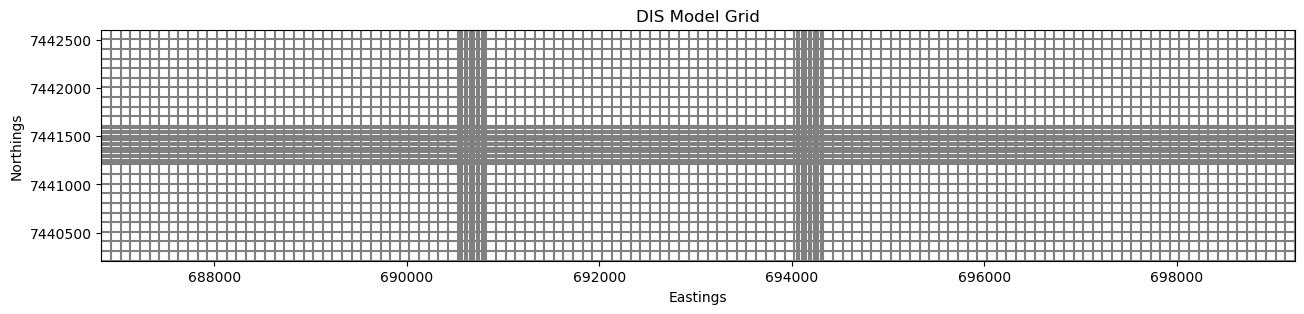

In [41]:
# get a modelgrid object and plot the grid
mg = gwf.modelgrid
fig,ax = plt.subplots(figsize=(20,3)) # we are creating a figure object here so that we can dictate size
mg.plot(ax=ax)
ax.ticklabel_format(style='plain') # test what happens if you don't use this switch
ax.set_title('DIS Model Grid')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'DIS_model_grid.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'DIS_model_grid.pdf')
fig.savefig(figname,dpi=300) 

# Using grid intersect to select nodes for idomain

We will use Flopy's grid intersect methods with the polygon of the model domain to select the active nodes.

In [42]:
from flopy.utils import GridIntersect # first import the GridIntersect class
from shapely.geometry import Polygon
import shapefile

In [43]:
# Now we need to deactivate the model cells that are outside the model domain
# start by creating the idomain array
idom = np.zeros((nlay,new_nrow,new_ncol))

# now we create an intercetion object specifying a method for structured grids
ix = GridIntersect(mg, method="structured") # note that we have to pass it a modelgrid object

# create a pth to the shapefile
shp_path = os.path.join(gis_f,'sgrid_poly.shp')

# read in the shapefile
sf = shapefile.Reader(shp_path)

# Create a shapely polygon object from the points stored in the shapefile
poly = Polygon(shell=sf.shape(0).points)

In [44]:
result = ix.intersect(poly) # perform the intersection
# note the intersection has other information but for now we will only use the cell_ids
# we can use the cell ids to set idomain
_ = result.cellids

In [46]:
_

array([(0, 49), (0, 50), (0, 51), ..., (35, 111), (35, 112), (35, 113)],
      dtype=object)

In [45]:
for item in _: # loop through all the selected cell ids
    idom[0][item[0]][item[1]] = 1 # make them equal to 1
idom

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [47]:
# create a new dis object and export the grid as a shape file
x = 686825.7084327207412571
y = 7440206.9828847106546164
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,
                              nrow=new_nrow,
                              ncol=new_ncol,
                              delr=new_delc,
                              delc=new_delr,
                              top=top,
                              botm=botm,
                              xorigin=x,
                              yorigin=y,
                              idomain=idom) # creating the dis object
dis.export(os.path.join(gis_f,'dis_idom.shp')) # ignore the warnings
# Note the exported shapefile has the idomain value for each node included so you can check if your 
# intersection was correct. 

C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


# Points to consider
1. Discretization efficiency
2. What happens if there are more layers
3. Can we do it better?

# Discretization by vertices (DISV) and Gridgen

The use of control-volume finite-difference facilitates unstructured model grids. Modflow-6 includes two discretization types for this purpose DSIV and DISU. The primary differenrce between the two is that DISU allows for different numbers of nodes/cells in different layers and/or different locations of nodes/cells in different layers. DISV must have the same pattern of nodes and cells in each layer. Instead of (layer, row, column), indexing for nodes, DISV has (layer, node number) while DISU has node number only. You will become more familiar with these differences when we start working with boundary conditions.

This allows for more efficient model mesh designs with regards to node numbers. In the following example we will construct a quadtree refined model mesh using Gridgen and Flopy. Gridgen is included in the USGS binaries that you can download from [here](https://github.com/MODFLOW-USGS/executables).

A polygon representing a new model domain is provided in addition to all the shape files that Gridgen will need to build the grid for you. These will be copied to your workshop_2 GIS folder. Take a look at the shape files in your preferred GIS program noting the projection from any one of the prj files.

In [48]:
# Copy all the files in the disv_shapefiles subdirectory in files to your GIS folder
shp_path = os.path.join('files','disv_shapefiles') # path to shapefiles for this example
flist = [x for x in os.listdir(shp_path)] # create a list of all the shapefiels
for file in flist:
    shutil.copyfile(os.path.join(shp_path,file),os.path.join(gis_f,file)) 
# Now have a look at all the shape files in your preferred GIS tool.

In [49]:
# Create a dummy model and regular grid to use as the base grid for gridgen
# You should be familiar with evrything used in this block of code
sim_name = "MySim"
model_name = "flow"

sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

nlay = 3
nrow = 34
ncol = 44
delr = delc = 1280.0 # Why do you think am I choosing this value? It has to do with quadtree refinement.
botm = np.zeros((nlay, nrow, ncol))
top = np.zeros((1, nrow, ncol)) # note the use of 1. Why?
idom = np.ones((nlay, nrow, ncol))
botm[0, :, :] = 270.0 # Setting the bottom for layer 1
botm[1,:,:] = 200.0 # Setting the bottom for layer 2
botm[2,:,:] = -170.0 # Setting the bottom for layer 3
top[0,:,:] = 460.0 # Setting the top for layer 1

# Note we start with a structured DIS grid despite aiming for a DISV grid.
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=729425, # new location
    yorigin=947000, # new location
    length_units='meters',
    angrot=0,
    idomain = idom
)
dis.export(os.path.join(gis_f,'disv.shp'))
# check that the exported disv shapefile covers the polygon for the model boundary.

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


# Checking for Gridgen on your system

In [50]:
from flopy.utils.gridgen import Gridgen
gridgen_exe = "gridgen"
if platform.system() in "Windows":
    gridgen_exe += ".exe"
gridgen_exe = flopy.which("gridgen")
if gridgen_exe is None:
    msg = (
        "Warning, gridgen is not in your path. "
        "When you create the griden object you will need to "
        "provide a full path to the gridgen binary executable."
    )
    print(msg)
else:
    print("gridgen executable was found at: {}".format(gridgen_exe))

gridgen executable was found at: C:\mffiles\gridgen.EXE


# Using Flopy to run Gridgen

In [51]:
# create a path to a folder where we will store gridgen files
mg = gwf.modelgrid
g = Gridgen(mg) # creating the gridgen object and passing in our structured dis object

# Here we are just creating paths to the shape files
# note that we don't use the .shp extension
dam = os.path.join(gis_f,"dam_buffer")
chanel = os.path.join(gis_f,"my_channels")
tsf = os.path.join(gis_f,"tsf_buffer")
wels = os.path.join(gis_f,"Wells_buffered")
pit1500 = os.path.join(gis_f,"pits_buffer_1500")
pit1000 = os.path.join(gis_f,"pits_buffer_1000")
pit500 = os.path.join(gis_f,"pits_buffer_500")
mod_bnd = os.path.join(gis_f,"model_bounds")
act_dom = os.path.join(gis_f,"model_bounds_poly")

# this section adds the shape files to be used as refinement features
# We also add an active domain shap eat the end
# note we have an increasing order of refinement as we add the features
# what cell size does 5 levels of refinement produce if we start from 1280.0 m
# we ask for the refinements to be applied in all layers because we will be using disv
# what do you think will happen if we only refine in layer 1?

g.add_refinement_features(mod_bnd, "line", 2, layers=[0,1,2]) # the model boundary, a line feature, refinement level 2, all layers
g.add_refinement_features(chanel, "line", 3, layers=[0,1,2]) # the ephemeral channels, a line feature, refinement level 3, all layers
g.add_refinement_features(wels, "polygon", 3, layers=[0,1,2]) # the well bore locations, a polygon feature, refinement level 3, all layers
g.add_refinement_features(dam, "polygon", 3, layers=[0,1,2]) # the dewater dam, a polygon feature, refinement level 3, all layers
g.add_refinement_features(tsf, "polygon", 3, layers=[0,1,2]) # the TSF, a polygon feature, refinement level 3, all layers
g.add_refinement_features(pit1500, "polygon", 3, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 3, all layers
g.add_refinement_features(pit1000, "polygon", 4, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 4, all layers
g.add_refinement_features(pit500, "polygon", 5, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 5, all layers
g.add_active_domain(act_dom,layers=[0,1,2]) # add the active domain for all layers
g.build() # build the grid

# Move the new grid shape files to our GIS folder

In [52]:
# get a list of the files and copy them to GIS folder
grd_files = [file for file in os.listdir('.') if file.startswith("qtgrid")]
for file in grd_files:
    shutil.copyfile(file,os.path.join(gis_f,file))
# note these files don't have any projection but the nodes and vertices are correct 
# because they were derived from the original structured grid object 

# Get the new grid properties

These are needed to build a DISV grid object.
    
While we are at it lets look at the grid via a modelgrid instance directly. 
Note this is different to how we were doing it previously where we first built a discretisation object then a modelgrid.

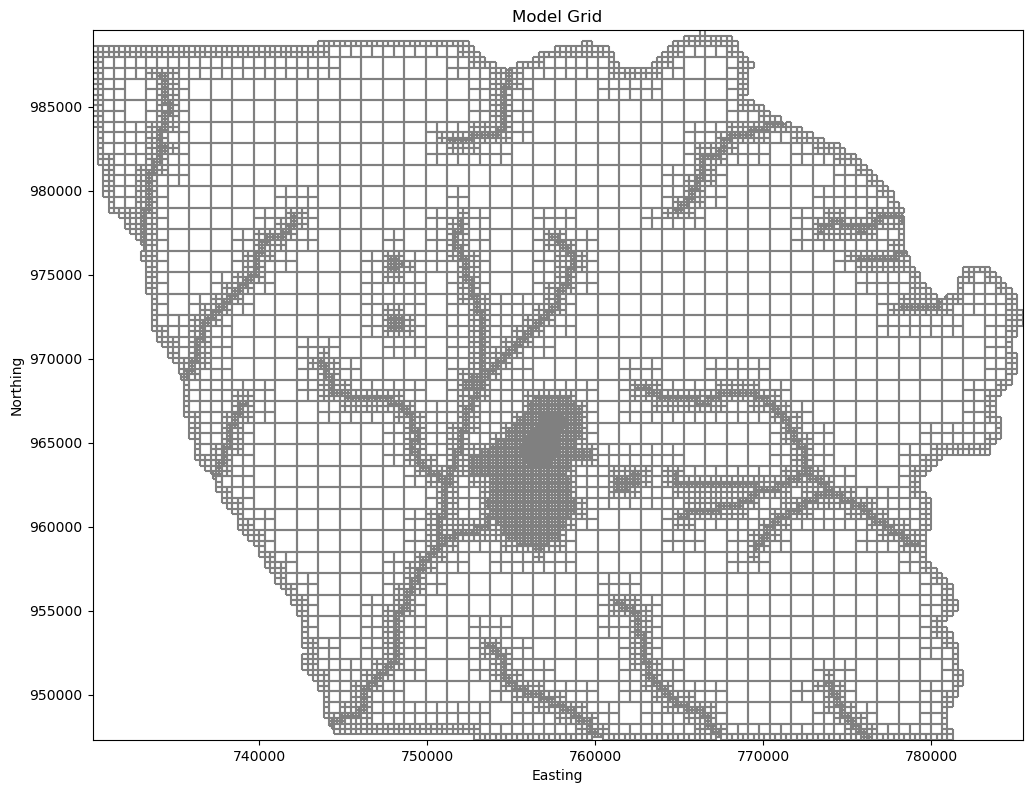

In [53]:
# get the gridprops for a disv type modelgrid
# note this method is for a modelgrid object specifically, there are also methods for discretization objects
gridprops_vg = g.get_gridprops_vertexgrid() 

# create a vertex modelgrid using the gridprops, this is why we used a method to get modelgrid properties
vgrid = flopy.discretization.VertexGrid(**gridprops_vg) # You've seen a list unpack before using *list, this is a dictionary unpack using **dict

#Call a figure so that we can make a larger plot
fig,ax = plt.subplots(figsize=(12,12)) # set a large figure size
vgrid.plot(ax=ax) # pass in the axes for the current figure
#BAM! Try doing that manually without Gridgen.

# Since we already have a figure instance lets save this in our plots folder
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.title('Model Grid')
figname = os.path.join(plots_f,'model_grid.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'model_grid.pdf')
fig.savefig(figname,dpi=300) 

# Creating a DISV object

So far we built a grid with Gridgen and from that we created a modelgrid object but we haven't created a discretisation object for our model just yet. Note if you don't rebuild your model object then you may get an error because it assumes you are trying add another discretisation object.

In [54]:
del gwf
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

# Now lets get the properties for a disv object. Note the method is different and is specific to a disv type object
gridprops_disv = g.get_gridprops_disv()

# Note use of mf6.ModflowGwfdisv, passing in the model object (gwf) and unpacking the grid properties dictionary
disv = flopy.mf6.ModflowGwfdisv(gwf,length_units="METERS", **gridprops_disv)
# ignore the warning

In [55]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package disv...


In [56]:
# Now look at the flow.dis input file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,"flow.disv"))] # note the file now ends with .disv instead of .dis

# File generated by Flopy version 3.4.1 on 09/25/2023 at 13:20:25.
BEGIN options
  LENGTH_UNITS  meters
END options

BEGIN dimensions
  NLAY  3
  NCPL  12262
  NVERT  14260
END dimensions

BEGIN griddata
  top
    INTERNAL  FACTOR  1.0
       460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000
       460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000     460.00000000
       460.00000000     460.00000000     460.00000000     460.00000000     460

# Gridgen Files

Gridgen creates lots of files. Look in the folder where this notebook resides. You will find many files that were created when you ran Gridgen. The files start with similar prefixes either 'qtg.', 'quadtree', '_gridgen' or 'qtgrid'. The 'qtgrid' files are shapefiles that can be used to view your grid in a GIS. The other files contain information about the grid plus the actual input files that Flopy wrote in order to run Gridgen for you. If you are interested in the details of the other files then consider downloading the Gridgen suite [here](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) where you can access a copy of the user manual. Note this manual will show you how to create the input files for Gridgen and how to run it form command line. It does not include information on using Gridgen with Flopy. The suite also includes the Gridgen executable but the one linked to earlier, which is provided as part of the USGS groundwater modelling binaries is the one you should be using with Flopy.

Lets tidy things up a bit and move the files created by Gridgen into a sub-directory in our workshop folder.

In [57]:
# make a path to where we want our new folder
grid_path = os.path.join(ws2,'Gridgen')
# now make the folder by checking if it exists first, deleting it, then making it
if os.path.exists(grid_path): # here we are asking if the path exists on the computer. 
    shutil.rmtree(grid_path)# if it does exist, delete it and all the files in it plus any subdirectories
    os.mkdir(grid_path) # then remake it
else:
    os.mkdir(grid_path) # if it doesn't exist then make the folder
# now make a list of all the files we want to move
# We will use the start of the different filenames to identify them
flist = [] # start with an empty list
for pref in ['qtg', 'quadtree', '_gridgen',]: # kick off a for loop with a list of file prefixes
    temp_list = [x for x in os.listdir() if x.startswith(pref)] # make a temporary list of the files that start with this loops prefix
    flist = [*flist,*temp_list] # unpack the existing list of files and the temporary list of files into the file list
# Before we move the files you should check that you haven't included any files you don't want to move.
flist

['qtg.area.dat',
 'qtg.c1.dat',
 'qtg.c2.dat',
 'qtg.fahl.dat',
 'qtg.fldr.dat',
 'qtg.gnc.dat',
 'qtg.ia.dat',
 'qtg.iac.dat',
 'qtg.ja.dat',
 'qtg.nod',
 'qtg.nodesperlay.dat',
 'qtg.vtu',
 'qtgrid.dbf',
 'qtgrid.shp',
 'qtgrid.shx',
 'qtgrid_pt.dbf',
 'qtgrid_pt.shp',
 'qtgrid_pt.shx',
 'qtg_sv.vtu',
 'quadtreegrid.bot1.dat',
 'quadtreegrid.bot2.dat',
 'quadtreegrid.bot3.dat',
 'quadtreegrid.dfn',
 'quadtreegrid.top1.dat',
 'quadtreegrid.top2.dat',
 'quadtreegrid.top3.dat',
 'quadtreegrid.tsf',
 '_gridgen_build.dfn',
 '_gridgen_export.dfn']

In [58]:
# If that looks good then we move the files to our new folder
for file in flist:
    shutil.move(file,grid_path) # note use of move as opposed to copyfile which we used earlier. 

# Raster sampling to assign layer elevations to model tops and bottoms

If you plan to use interpolated elevations for your aquifer top and bottoms plus a DEM for your model surface then using Flopy's Raster class and methods is very useful. For the sake of brevity we will only do this for the model surface but the same method can be used for all model layers. The approach demonstrated below uses a .tif file that was created in a GIS. In this instance the tif file only has a single band. You can create tif files through interpolation of point data within a GIS if your aim is to create layer elevations.

In [60]:
# Lets copy the file from the ./files folder to our GIS folder for this workshop
fnam = 'filled_dem.tif' # the name of the the tif file we are going to use
shutil.copyfile(os.path.join(fpath,fnam),os.path.join(gis_f,fnam))

'workshop_2\\GIS\\filled_dem.tif'

In [61]:
from flopy.utils import Raster # first import the Raster class
mg = gwf.modelgrid # make sure your modelgrid is associated with the current model and it's discretization object
topo_fyl = os.path.join(gis_f,'filled_dem.tif') # path to our copied tif file
rio1 = Raster.load(topo_fyl) # Load the file 
rio1.bands # check how many bands

(1,)

In [62]:
# Here is where we sample the raster to the modelgrid 
top_data = rio1.resample_to_grid(   #using the resample_to_grid method
    mg, band=rio1.bands[0], # stipulating the first band in the raster file to be used as the data for sampling
    method="nearest" # setting an interpolation method because it is highly unlikley that your model grid nodes will align with the raster data points 
)
print(np.shape(top_data)) # the shape of the array should match a layer in your model. Recall with DISV all layers have the same node pattern 
top_data
#*** WARNING you haven't assigned this to the model yet, you only have the data ***

(12262,)


array([328.0072937 , 381.01364136, 385.        , ..., 291.08908081,
       294.0005188 , 292.00531006])

In [63]:
# Here is where we assign the data to the discretization object
disv.top.data 
disv.top = top_data
disv.top.data 
# *** WARNING you've changed the disv object but not the modelgrid ****

array([328.0072937 , 381.01364136, 385.        , ..., 291.08908081,
       294.0005188 , 292.00531006])

In [64]:
# as a precaution whenever you make changes to your discretisation object you should rebuild your modelgrid
mg = gwf.modelgrid
# this ensures that if you use methods that call on the modelgrid for information then it will be updated

# Plotting the Raster

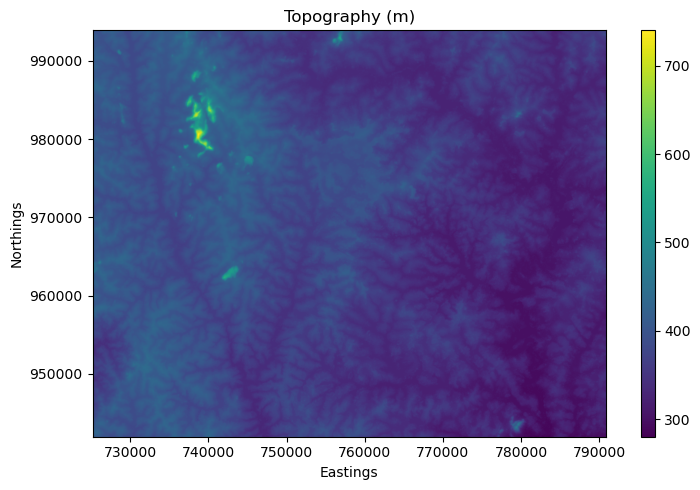

In [65]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax = rio1.plot(ax=ax)
plt.colorbar(ax.images[0], aspect=30)
ax.set_title('Topography (m)')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
ax.ticklabel_format(style='plain') #  gets rid of the exponent offsets on the axis
plt.tight_layout()

# Plotting with the Mapview object

Plotting the raster is nice but this doesn't give you the information mapped to the grid for that you need to plot with the Mapview object. We will be using this all the time for viewing model results and input data like boundary conditions.

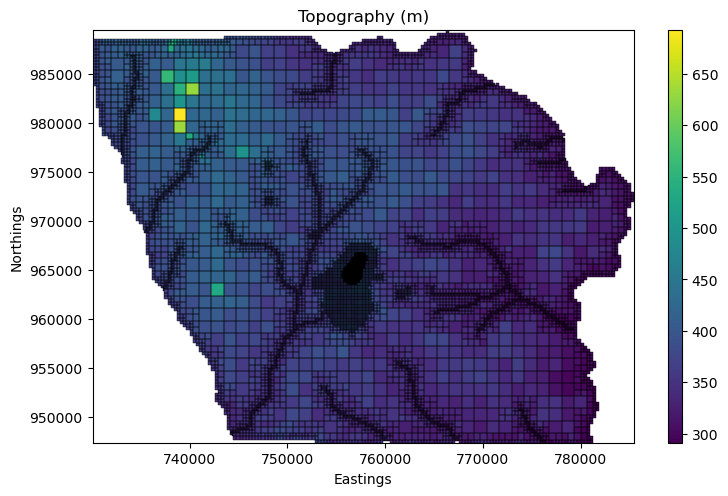

In [66]:
fig = plt.figure(figsize=(8, 5)) # Creating a figure and axes object plus setting the figure size
ax = fig.add_subplot(1, 1, 1, aspect="equal") # setting the aspect for a single plot, aspect keeps the scale of the x and y axes correct 
# note the 1,1,1 above means 1 row, 1 column, the first plot

pmv = flopy.plot.PlotMapView(modelgrid=mg, layer = 0) #creating a mapview object
pmv.plot_grid(ax=ax, lw=0.3, color="black") # plot the grid on the axes using linewidths = 0.3 and black lines
# Note that the line above is not given an object name, we could have done this if we wanted to
map1 = pmv.plot_array(mg.top) # here I am passing in an array from the modelgrid, I could also have used disv.top.data instead
# The line above here is assigned an object name because I need to provide it to the line below which creates the colorbar
plt.colorbar(map1,aspect=30) # create a colorbar specific to the array that was plotted, 
# you can control the size of the colorbar with aspect and shrink.
ax.set_title('Topography (m)') 
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
ax.ticklabel_format(style='plain') #  gets rid of the exponent offsets on the axis
plt.tight_layout() # reduces the whitespace around the figure so it takes up less space in a document

# Pinching out layers with IDOMAIN

Assume that we assigned elevations to all our layers but they intersect one another. This means that the some of the aquifers don't exist in certain locations. The modelgrid object stores this information as thickness. If the thickness is less than zero then the layer representing that aquifer does not exist according to our interpolation. ***warning*** As a modeller you need to know the difference between interpolation and extrapolation; moreover, you need to think carefully about how much you really know and what is assumption. The code block below simply assigns a negative value to any location where the model thickness is less than zero creating you idomain for pinching out layers.

If you don't pinch out a negative thickness cell, MF6 will fail to run and inform you that you have negative thickness. Before you decide to pinch out you need to make sure that layer elevations are correct.

In [67]:
# Start with the modelgrid thickness
thick = mg.cell_thickness
# now idomain will be the same shape array as thick so we can use a handy feature of numpy
idom = np.ones_like(thick) # creates an array of ones
idom[thick<0.0]=-1 # this is basically saying that wherever thick is less than zero make idom equal to -1
# in this case we don't have any pinchouts but I included this for completeness

In [68]:
# then we can assign the is to our disv object
disv.idomain = idom
# don't forget to rebuild modelgrid now that idom is uppdated
mg = gwf.modelgrid

# What about DISU?

As mentioned previously Gridgen was originally developed to create DISU type model grids for MODFLOW-USG. We can repeat everyhting we just did but use DISU instead.

In [69]:
# Create a dummy model and regular grid to use as the base grid for gridgen
# You should be familiar with evrything used in this block of code
sim_name = "MySim"
model_name = "flow"

sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

nlay = 3
nrow = 34
ncol = 44
delr = delc = 1280.0 # Why do you think am I choosing this value? It has to do with quadtree refinement.
botm = np.zeros((nlay, nrow, ncol))
top = np.zeros((1, nrow, ncol)) # note the use of 1. Why?
idom = np.ones((nlay, nrow, ncol))
botm[0, :, :] = 270.0 # Setting the bottom for layer 1
botm[1,:,:] = 200.0 # Setting the bottom for layer 2
botm[2,:,:] = -170.0 # Setting the bottom for layer 3
top[0,:,:] = 460.0 # Setting the top for layer 1

# Note we start with a structured DIS grid despite aiming for a DISV grid.
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=729425, # new location
    yorigin=947000, # new location
    length_units='meters',
    angrot=0,
    idomain = idom
)
dis.export(os.path.join(gis_f,'disv.shp'))
# check that the exported disv shapefile covers the polygon for the model boundary.

# create a path to a folder where we will store gridgen files
mg = gwf.modelgrid
g = Gridgen(mg) # creating the gridgen object and passing in our structured dis object

# Here we are just creating paths to the shape files
# note that we don't use the .shp extension
dam = os.path.join(gis_f,"dam_buffer")
chanel = os.path.join(gis_f,"my_channels")
tsf = os.path.join(gis_f,"tsf_buffer")
wels = os.path.join(gis_f,"Wells_buffered")
pit1500 = os.path.join(gis_f,"pits_buffer_1500")
pit1000 = os.path.join(gis_f,"pits_buffer_1000")
pit500 = os.path.join(gis_f,"pits_buffer_500")
mod_bnd = os.path.join(gis_f,"model_bounds")
act_dom = os.path.join(gis_f,"model_bounds_poly")

# this section adds the shape files to be used as refinement features
# We also add an active domain shap eat the end
# note we have an increasing order of refinement as we add the features
# what cell size does 5 levels of refinement produce if we start from 1280.0 m
# Here some features are only being refined in layer 1
# this will result in different numbers of nodes in subsequent layers

g.add_refinement_features(mod_bnd, "line", 2, layers=[0,1,2]) # the model boundary, a line feature, refinement level 2, all layers
g.add_refinement_features(chanel, "line", 3, layers=[0]) # the ephemeral channels, a line feature, refinement level 3, all layers
g.add_refinement_features(wels, "polygon", 3, layers=[0,1,2]) # the well bore locations, a polygon feature, refinement level 3, all layers
g.add_refinement_features(dam, "polygon", 3, layers=[0]) # the dewater dam, a polygon feature, refinement level 3, all layers
g.add_refinement_features(tsf, "polygon", 3, layers=[0]) # the TSF, a polygon feature, refinement level 3, all layers
g.add_refinement_features(pit1500, "polygon", 3, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 3, all layers
g.add_refinement_features(pit1000, "polygon", 4, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 4, all layers
g.add_refinement_features(pit500, "polygon", 5, layers=[0,1,2]) # buffered area around the planned mine pits, a polygon feature, refinement level 5, all layers
g.add_active_domain(act_dom,layers=[0,1,2]) # add the active domain for all layers
g.build() # build the grid


C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


In [71]:
# Where thinga are different
# get the gridprops for a disu type grid
gridprops_disu = g.get_gridprops_disu6() # there is also a disu5 method which is specific to MODFLOW-USG

# Note if we wanted the properties for the modelgrid instead we would use g.get_gridprops_unstructuredgrid()
# but in this case we are going for the discretization object

In [72]:
del gwf
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file
# Note use of mf6.ModflowGwfdisv, passing in the model object (gwf) and unpacking the grid properties dictionary
disu = flopy.mf6.ModflowGwfdisu(gwf,length_units="METERS", **gridprops_disu)
# ignore the warning
# Thats it now you have a DISU
# rebuild our modelgrid
mg = gwf.modelgrid # this way we don't need to get the grid properties from the Gridgen object

# Different nodes in different "layers"

The concept of layers is completley absent in a DISU grid. However, our modelgrid still has some "layer" information in it via a property called ncpl. NCPL (or number of cells per layer) is implemented in DISV (and in MF-USG DISU). This means you can still pass a "layer" to the Mapview object.

In [73]:
# lets look at the ncpl for our current model grid
mg.ncpl

array([12262,  8562,  7035])

In [74]:
# Note the disu object has no ncpl and the top and borrom arrays are 1D
disu

package_name = disu
filename = flow.disu
package_type = disu
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
('meters')

vertical_offset_tolerance
{internal}
(0.0)


Block dimensions
--------------------
nodes
{internal}
(27859)

nja
{internal}
(185201)

nvert
{internal}
(111436)


Block griddata
--------------------
top
{internal}
(array([460., 460., 460., ..., 200., 200., 200.], dtype=float32))

bot
{internal}
(array([ 270.,  270.,  270., ..., -170., -170., -170.], dtype=float32))

area
{internal}
(array([102400., 102400., 102400., ..., 102400., 102400., 102400.],
      dtype=float32))


Block connectiondata
--------------------
iac
{internal}
(array([3, 4, 5, ..., 4, 5, 4]))

ja
{internal}
(array([    0,   176, 12262, ..., 20823, 27856, 27857]))

ihc
{internal}
(array([0, 1, 0, ..., 0, 1, 1]))

cl12
{internal}
(array([  0., 160.,  95., ..., 185., 160., 160.], dtype=float32))

hwva
{internal}
(array([     0.,    320., 

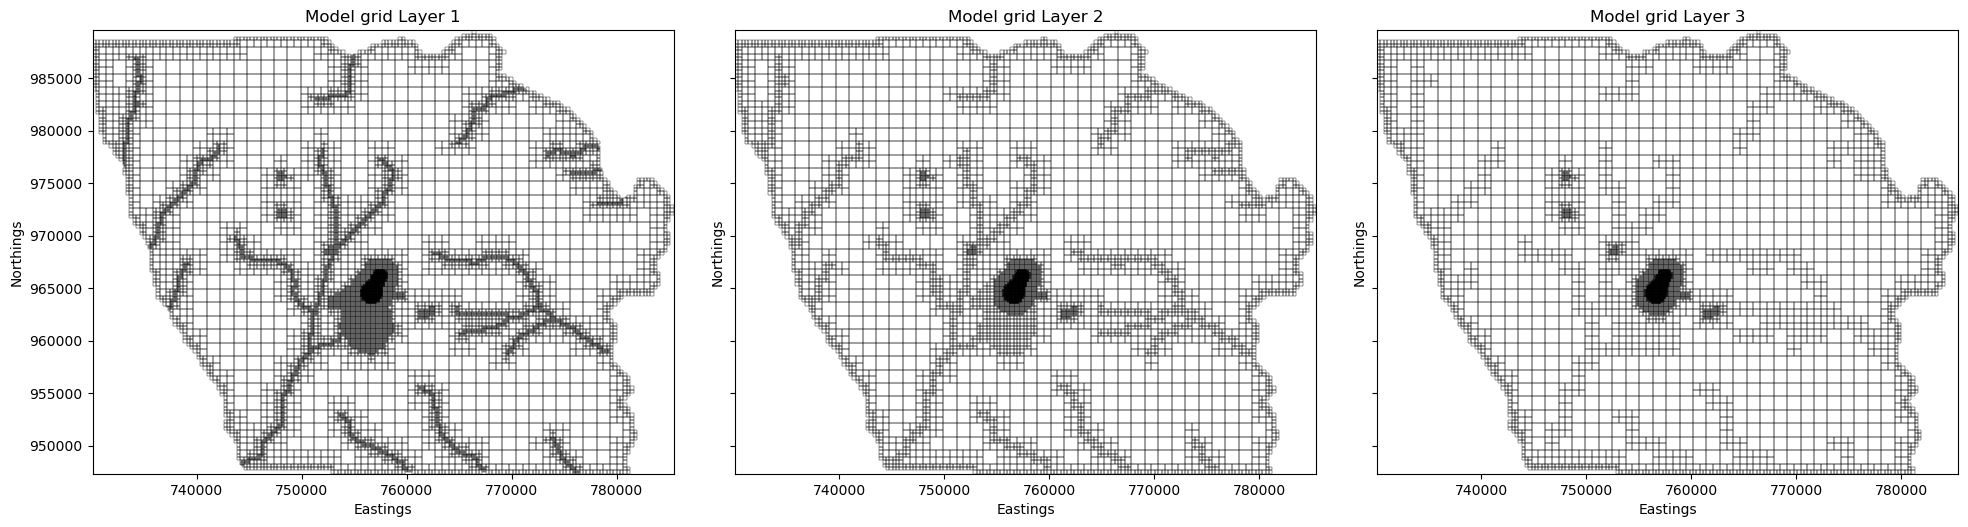

In [75]:
# Using Matplotlib subplots to create a mutiple axes figure
fig, axs = plt.subplots(nrows = 1, # I want one row
                        ncols = 3, # I want three columns
                        sharey=True, # they can share the Y-axis to save space
                        subplot_kw={'aspect':'equal'}, # Each sub_plot must have aspect = equal to keep x and y ratios consistent
                        figsize=(20, 5)) # setting figure size Note had to increase the x dimension here

for i,ax in enumerate(axs):
    pmv = flopy.plot.PlotMapView(modelgrid=mg, layer = i, ax=ax) #creating a mapview object assigning a specific layer and specifying the axes
    pmv.plot_grid(ax=ax, lw=0.3, color="black") # plot the grid on the axes using linewidths = 0.3 and black lines
    ax.set_title(f'Model grid Layer {i+1}') 
    ax.set_xlabel('Eastings')
    ax.set_ylabel('Northings')
    ax.ticklabel_format(style='plain') #  gets rid of the exponent offsets on the axis
plt.tight_layout() # reduces the whitespace around the figure so it takes up less space in a document

figname = os.path.join(plots_f,'model_grid_disu.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'model_grid_disu.pdf')
fig.savefig(figname,dpi=300) 

In [76]:
# Tidy up again
# We clear the existing directory first
if os.path.exists(grid_path): # here we are asking if the path exists on the computer. 
    shutil.rmtree(grid_path)# if it does exist, delete it and all the files in it plus any subdirectories
    os.mkdir(grid_path) # then remake it
else:
    os.mkdir(grid_path) # if it doesn't exist then make the folder
flist = [] # start with an empty list
for pref in ['qtg', 'quadtree', '_gridgen',]: # kick off a for loop with a list of file prefixes
    temp_list = [x for x in os.listdir() if x.startswith(pref)] # make a temporary list of the files that start with this loops prefix
    flist = [*flist,*temp_list] # unpack the existing list of files and the temporary list of files into the file list
# No need to check now because we did previously
for file in flist:
    shutil.move(file,grid_path) # note use of move as opposed to copyfile which we used earlier. 

# Layer elevations DISU vs DISV
How array type information is stored differs between DISU and DISV. This means we need to do something different when it comes to assigning layer elevations. However, we can exploit the modelgrid objects ncpl to help us out.

In [77]:
# look at the disu object. Note how the top and bottom arrays are 1D (or list-like). 
# This is beacuse the concept of layers does not exist in MF6 DISU, they do in MF-USG DISU
np.shape(disu.top.data)

(27859,)

In [78]:
# Here is where we sample the raster to the modelgrid 
top_data = rio1.resample_to_grid(   #using the resample_to_grid method
    mg, band=rio1.bands[0], # stipulating the first band in the raster file to be used as the data for sampling
    method="nearest" # setting an interpolation method because it is highly unlikley that your model grid nodes will align with the raster data points 
)
print(f'top_data shape is {np.shape(top_data)}') # note this array is the same size as all of the nodes in the model because we can't specify a layer.
# BUT these elevation will be assigned to all nodes irrespective of layer, so we can'just assign top_data to the disu object.
print(f'disu.top.data shape is {np.shape(disu.top.data)}')

top_data shape is (27859,)
disu.top.data shape is (27859,)


In [80]:
print(disu.top.data)
# We can slice according to layers in the ncpl
disu.top.data[0:mg.ncpl[0]] = top_data[0:mg.ncpl[0]] # Note the slices are the same on both sides of the assignment because the array sizes are the same
# note also we are changing the disu object directly with the data we just sampled but only a slice of it.
# WARNING if you try the same thing using disu.top.data it won't change anything. 

[328.0073  381.01364 385.      ... 200.      200.      200.     ]


That should cover most of what you might want to do with all the different grid types. There are other mesh creation tools like Triangle that have also been included in Flopy. The popular mesh generation utility AlgoMesh is based on Triangle and is a very good piece of software that creates highly optimised model grids but it also requires a license. It works similar to Gridgen but is able to do a whole lot more so well worth checking out if you get the chance. 

# Cross-Section type model grids

A cross-section model grid follows the same approach as what you would do for a single layer 2D model. The only difference is that the number of rows becomes one and the number of layers will be whatever you want your vertical resolution to be. Plotting is a little bit different however because it requires the use of Flopy's PlotCrossSection method. The example below steps through creation of a strcutured grid as cross section. Note use of cross-sectional models should ensure that the grid is aligned with the dominant flow path. This means that you will most likely have to rotate the grid.

Use of idomain and assigning tops and bottoms follows the same methods demonstrated previously.

In [81]:
# Setup a new sim
simulation_name = 'MySim' # setting a name for our simulation
sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
model_name = 'flow' # setting a name for our model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

In [82]:
nlay = 20 # more layers 
nrow = 1 # one row
ncol = 124
delc = 1.0 # one meter thickness for our single row
delr = 20.0
top = 279.0

# here I am asking for an array that will have the first value at 270 and the final value at 100
# but divided into the same number of layers that I want in my cross section
botm = np.linspace(270.,100.,nlay) 
x = 686825.7084327207412571
y = 7440206.9828847106546164
angrot = 15 # rotating to align with dominant flow direction
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,
                              delr=delr,delc=delc,top=top,
                              botm=botm, xorigin=x, yorigin=y,
                              angrot=angrot) # creating the dis object

In [83]:
# Lets take a quick look at the dis object
dis

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
xorigin
{internal}
(686825.7084327207)

yorigin
{internal}
(7440206.982884711)

angrot
{internal}
(15.0)


Block dimensions
--------------------
nlay
{internal}
(20)

nrow
{internal}
(1)

ncol
{internal}
(124)


Block griddata
--------------------
delr
{constant 20.0}

delc
{constant 1.0}

top
{constant 279.0}

botm
Layer_1{constant 270.0}
Layer_2{constant 261.05263157894734}
Layer_3{constant 252.10526315789474}
Layer_4{constant 243.1578947368421}
Layer_5{constant 234.21052631578948}
Layer_6{constant 225.26315789473685}
Layer_7{constant 216.31578947368422}
Layer_8{constant 207.36842105263156}
Layer_9{constant 198.42105263157896}
Layer_10{constant 189.4736842105263}
Layer_11{constant 180.5263157894737}
Layer_12{constant 171.57894736842104}
Layer_13{constant 162.6315789473684}
Layer_14{constant 153.68421052631578}
Layer_15{constant 144.736842

Text(0, 0.5, 'z position (m)')

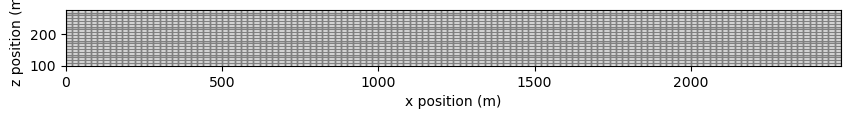

In [84]:
# Now to plot the grid in cross-section 
# note the PlotCrossSection object is analogous to the Mapview object we used previously.
fig = plt.figure(figsize=(10,3))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0}) # this will always be line={"row": 0} for a cross section model
pxs.plot_grid()
ax.set_xlabel("x position (m)")
ax.set_ylabel("z position (m)")

# Thats all folks

Next session will be on boundary conditions but will exclude array style boundaries like recharge and ET. We will introduce stress package observations and time the time series functionality which are both very handy features that are new to MODFLOW.